In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt 
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import csv
from datetime import datetime
import statsmodels.api as sm

In [2]:
# acquire
df=pd.read_csv('saas.csv')

In [3]:
# Check if acquire successfully
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# all columns have no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# Set up the environment for the upcoming test

In [6]:
# change datetime 
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)

In [7]:
# set amount as int
df.Amount=df.Amount.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month_Invoiced     790458 non-null  datetime64[ns]
 1   Customer_Id        790458 non-null  int64         
 2   Invoice_Id         790458 non-null  int64         
 3   Subscription_Type  790458 non-null  float64       
 4   Amount             790458 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 30.2 MB


In [8]:
df=df.drop(columns=['Customer_Id','Invoice_Id','Subscription_Type'])

In [9]:
# aand set it as index
df = df.set_index('Month_Invoiced')

In [10]:
df = df.resample('M')[['Amount']].sum()

In [11]:
# create a function to split data
def split_data(df):
    train_size = int(len(df) * .5)
    validate_size = int(len(df) * .3)
    test_size = int(len(df) - train_size - validate_size)
    validate_end_index = train_size + validate_size
    train = df[: train_size]
    validate = df[train_size : validate_end_index]
    test = df[validate_end_index :]
    train_val=pd.concat([train,validate],axis=0)
    return train,validate,test,train_val

In [12]:
# split data
train,val,test,train_val=split_data(df)

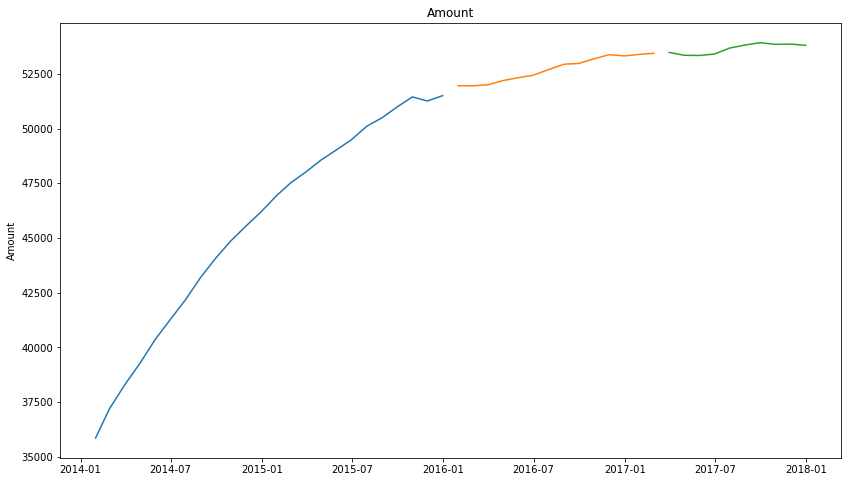

In [13]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(val[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [14]:
# evaluate RMSE
def evaluate(target):
    rmse = round(sqrt(mean_squared_error(val[target], yhat_df[target])), 0)
    return rmse

In [15]:
# create plot
def plot_and_eval(target):
    plt.figure(figsize = (10,4))
    plt.plot(train[target], label='Train', linewidth=1)
    plt.plot(val[target], label='Validate', linewidth=1)
    plt.plot(yhat_df[target])
    plt.title(target)
    rmse = evaluate(target)
    print(target, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [16]:
model_df = pd.DataFrame(columns=['model', 'target', 'rmse'])
model_df

,model,target,rmse


In [17]:
# create a dataframe
def model(model,target):
    rmse = evaluate(target)
    d = {'model': [model], 'target': [target],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return model_df.append(d, ignore_index = True)

In [18]:
# last observed value model.
# calculate yhat
Amount = train['Amount'][-1:][0]
yhat_df = pd.DataFrame({'Amount':[Amount]}, 
                       index = val.index)

yhat_df.head(2)

,Amount
Month_Invoiced,
2016-01-31,51505
2016-02-29,51505


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2014-01-31 to 2015-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Amount  24 non-null     int64
dtypes: int64(1)
memory usage: 384.0 bytes


Amount -- RMSE: 1343


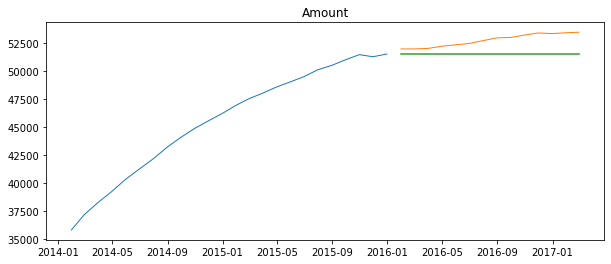

In [20]:
# plot it
plot_and_eval('Amount')

In [21]:
model_df=model(model='Last_Observed',target='Amount')
model_df

,model,target,rmse
0,Last_Observed,Amount,1343.0


In [22]:
# Simple Average
Amount = round(train['Amount'].mean(), 2)
yhat_df = pd.DataFrame({'Amount': [Amount]}, index = val.index)
yhat_df.head(3)

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54


Amount -- RMSE: 7181


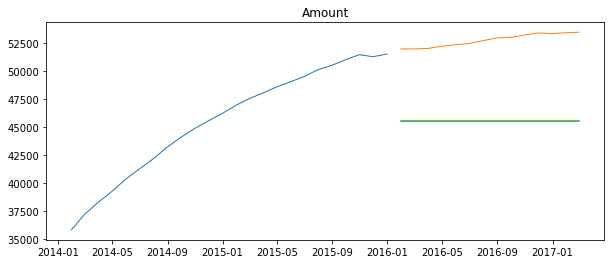

In [23]:
for col in train.columns:
    plot_and_eval(col)

In [24]:
model_df=model('Simple_Average',target='Amount')
model_df

,model,target,rmse
0,Last_Observed,Amount,1343.0
1,Simple_Average,Amount,7181.0


In [25]:
# moving average

period=3

Amount = round(train['Amount'].rolling(period).mean().iloc[-1], 2)


yhat_df = pd.DataFrame({'Amount': [Amount]}, index = val.index)
yhat_df.head(2)


,Amount
Month_Invoiced,
2016-01-31,51403.33
2016-02-29,51403.33


Amount -- RMSE: 1436


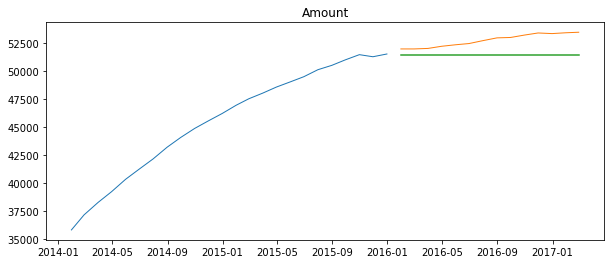

In [26]:
for col in train.columns:
    plot_and_eval('Amount')

In [27]:
model_df = model(model='30d moving average', 
                             target = 'Amount')


In [28]:
model_df

,model,target,rmse
0,Last_Observed,Amount,1343.0
1,Simple_Average,Amount,7181.0
2,30d moving average,Amount,1436.0


Amount 



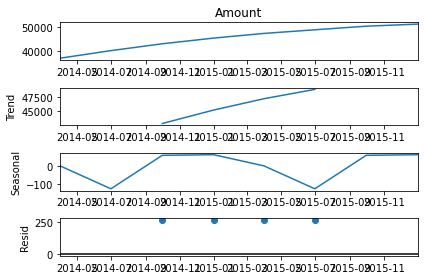

In [29]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('Q').mean()).plot()
plt.show()

In [30]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = val.index[0],
                              end = val.index[-1])
    yhat_df[col] = round(yhat_items,2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Amount -- RMSE: 6102


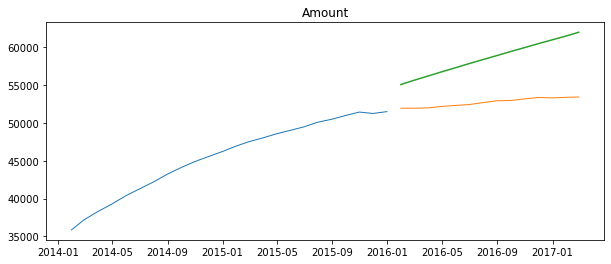

In [31]:
for col in train.columns:
    plot_and_eval(target = col)

In [32]:
for col in train.columns:
    model_df = model(model = 'Holts', 
                             target = col)
eval_df

TypeError: 'HoltWintersResultsWrapper' object is not callable

In [ ]:
# predict based on previous cycle
train = df[:'2015']
val = df['2016']
test = df['2017']

In [ ]:
yhat_df = train['2015'] + train.diff(12).mean()

In [ ]:
pd.concat([yhat_df.head(1), val.head(1)])

In [ ]:
yhat_df.index = val.index

In [ ]:
for col in train.columns:
    plot_and_eval(target = col)
    model_df = model(model= 'previous year', target = col)

In [34]:
model_df

,model,target,rmse
0,Last_Observed,Amount,1343.0
1,Simple_Average,Amount,7181.0
2,30d moving average,Amount,1436.0
